In [3]:
import sys
sys.path.insert(1, 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\impedance.py') #\\impedance')
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

from impedance.circuits import CustomCircuit
from impedance.plotting_BG import plot_nyquist
from impedance import preprocessing
from impedance import validation
from impedance.valid_BG import linKK

import ImpedanceCorrection as IC
import IC_plotting
%reload_ext autoreload
%autoreload 2

In [4]:
direc = r'\Data'
print(os.getcwd())
all_files=glob.glob(os.getcwd() + direc + '\*10%*.par')
all_files.sort()

f_name=all_files[-1]
print(f_name)
f0, Z0= preprocessing.readVersaStudio(f_name)

freqs, Z1 = preprocessing.ignoreBelowX(f0, Z0)

Z = Z1 - Z1.real[0]

C:\Users\shadd\OneDrive\Documents\Python\EIS
C:\Users\shadd\OneDrive\Documents\Python\EIS\Data\LSC_DPB1_FRXAS_700C_10%_EIS_OCV_afterFRXAS.par


In [530]:
M, mu, Z_linKK, res_real, res_imag = linKK(freqs, Z1, c=.8, max_M=100)

10 0.9994888642593683 4.660846484756838
20 0.9331215239742053 1.553542595904001


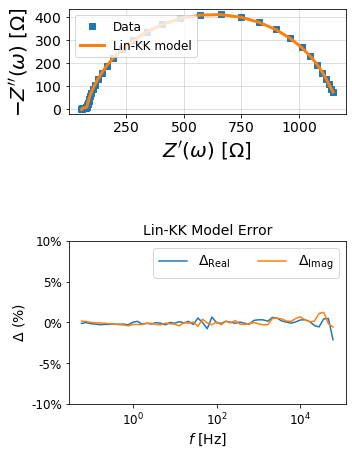

In [531]:
fig = plt.figure(figsize=(5,8))
gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[:2,:])
ax2 = fig.add_subplot(gs[2,:])

# plot original data
plot_nyquist(ax1, freqs, Z1, fmt='s')

# plot measurement model
plot_nyquist(ax1, freqs, Z_linKK, fmt='-', scale=1e3, units='\Omega')

ax1.legend(['Data', 'Lin-KK model'], loc=2, fontsize=12)

# Plot residuals
ax2.plot(freqs, res_real, '-', label=r'$\Delta_{\mathrm{Real}}$')
ax2.plot(freqs, res_imag, '-', label=r'$\Delta_{\mathrm{Imag}}$')
ax2.set_title('Lin-KK Model Error', fontsize=14)

ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_ylabel('$\Delta$ $(\%)$', fontsize=14)
ax2.set_xlabel('$f$ [Hz]', fontsize=14)
ax2.set_xscale('log')
ax2.set_ylim(-.1, .1)

ax2.legend(loc=1, fontsize=14, ncol=2)

vals = ax2.get_yticks()
ax2.set_yticklabels(['{:.0%}'.format(x) for x in vals])

plt.tight_layout()
plt.show()

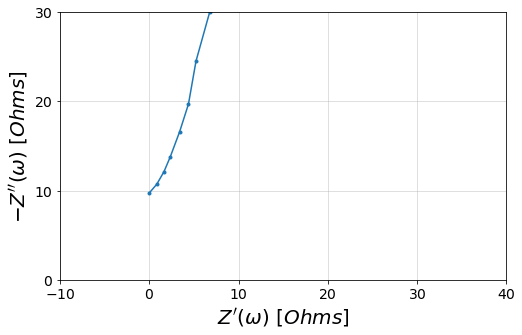

In [480]:
f_adj, Z_adj = freqs[18:], Z1[18:]

Z_adj = Z_adj - Z_adj.real[0]

fig, ax = plt.subplots(figsize=(8,8))

plot_nyquist(ax, Z_adj)

ax.set_xlim(-10, 40)
ax.set_ylim(0,30)
plt.show()

# fig.savefig(r'Figures\Berthier Correction\10%O2 Data Chop Zoom', dpi=300, bbox_inches='tight')

### Subtracting a Gerischer admittance from this using tg=0.7 as fit from fr-XAS
### Varying the Rg to see what might be appropriate

25 (688.949437291582-562.8324796479827j) 13.00746032382574 0 0
25 (676.9537470938902-553.6589792065262j) 10.4887267756352 0 0
25 (665.8809160557928-545.172480830495j) 8.232301060025065 0 0
25 (655.638876846533-537.3066692802452j) 6.203917360859009 0 0
25 (646.1472313800494-530.0033511146156j) 4.374679388938944 0 0
25 (637.3354573336685-523.2112477354639j) 2.720086849264078 0 0
25 (629.1414357221373-516.8849974946813j) 1.2192610227496061 0 0
25 (621.5102344356541-510.9843258285594j) -0.14567563851971954 0 0
25 (614.3930973032517-505.47335133152245j) -1.3900998488257983 0 0
25 (607.7465992873832-500.32000249352035j) -2.5272935297332992 0 0
25 (601.5319368125135-495.49552505375107j) -3.5687752768357655 0 0


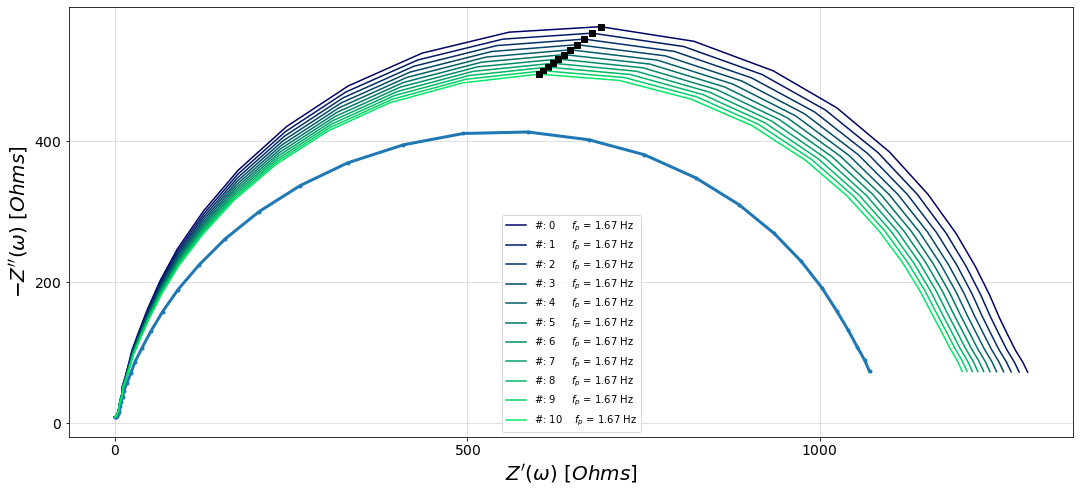

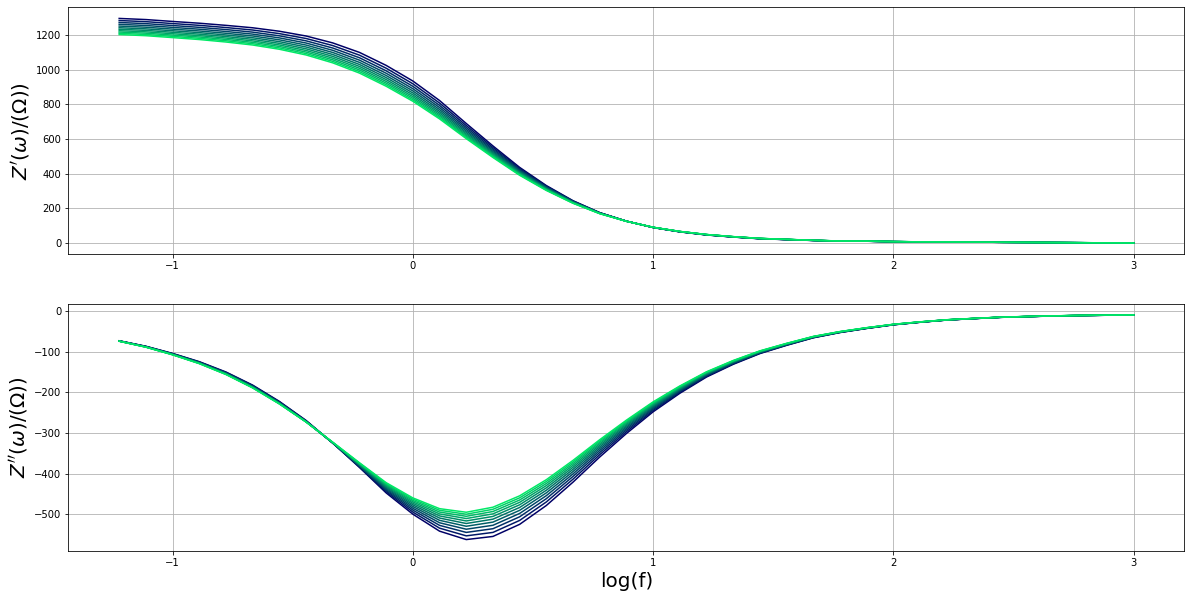

In [561]:
# par_out, ax0, ax1, ax2 = IC.sub_Zg_parallel(f_adj, Z_adj, .7, [3.3, 3.8], num=13)
par_out = IC.sub_Zg_parallel(f_adj, Z_adj, .7, [3.8, 4], num=11, show_plot=False)
# ax0.set_xlim((-2, 20))
# ax0.set_ylim((-2, 20))
fig, ax = plt.subplots(figsize=(18, 12))
fig2, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20, 10))
plot_nyquist(ax, freqs, Z_adj)

for i, Zs in enumerate(par_out):
#     print(sum(n < 0 for n in np.diff(Zs)), sum(n < -1 for n in Zs.real))
    min_ind = np.argmin(Zs.imag)
    print(min_ind, Zs[min_ind], Zs[min_ind+1].imag - Zs[min_ind-1].imag, sum(n < 0 for n in np.diff(Zs)), sum(n < -1 for n in Zs.real))
    if sum(n < 0 for n in np.diff(Zs)) == 0 and sum(n < -1 for n in Zs.real) < 2:
        f_p_idx = np.argmin(np.imag(Zs))
        f_p = f_adj[f_p_idx]

        ax.plot(Zs.real, -Zs.imag, label='#: %d \t $f_p$ = %.2f Hz' % (i, f_p),
                c=(0, i/len(par_out), .4))
        ax.plot(Zs[f_p_idx].real, -Zs[f_p_idx].imag, 's',
                c=(0, 0, 0))
        ax1.plot(np.log10(f_adj), Zs.real, label='%.2f Hz' % f_p,
                c=(0, i/len(par_out), .4))
        ax2.plot(np.log10(f_adj), Zs.imag, label='%.2f Hz' % f_p,
                c=(0, i/len(par_out), .4))

        # ax.set_xlim(-80, 300)
        # ax.set_ylim(-80, 300)
        ax2.set_xlabel(r'log(f)', fontsize=20)
        ax1.set_ylabel(r'$Z^{\prime} (\omega) / (\Omega))$', fontsize=20)
        ax2.set_ylabel(r'$Z^{\prime\prime} (\omega) / (\Omega))$', fontsize=20)
        ax1.grid(True)
        ax2.grid(True)
        ax.legend()

# fig.savefig(r'Figures\Berthier Correction\10%O2 Data Zg Subtraction Nyquist', dpi=300, bbox_inches='tight')
# fig2.savefig(r'Figures\Berthier Correction\10%O2 Data Zg Subtraction Bode', dpi=300, bbox_inches='tight')

In [668]:
def Res_fun(p, f, Z, tg):
    from impedance.circuit_elements import G
    Y = 1 / Z
#     p = [Rg[0], tg]
    try:
        Rg = p[0]
    except TypeError:
        print("Rg passed is not iterable. Using as float")
        Rg = p
    Zg = G([Rg, tg], f)
    Yg = 1 / Zg
    Y_adj = Y - Yg
    Z_adj = 1 / Y_adj
    diffed = np.diff(Z_adj.real)
    min_ind = np.argmin(Z_adj.imag)

    dum = np.sqrt((np.angle(Z_adj[0], deg=True) + 90)**2)
    curv = np.gradient(np.gradient(-Z_adj.imag, Z_adj.real), Z_adj.real)

    xdum = np.zeros(np.shape(curv), dtype=bool)
    xdum[-10:] = curv[-10:] > 0

    curv_res = sum(curv[xdum])
    print('curv_res = ', curv_res*10000, ' Rg = ', Rg)
    res = 0
    for n in range(1, len(Z_adj)-min_ind):
        res += (Z_adj[min_ind+n].imag - Z_adj[min_ind-n].imag)**2
    return res + sum(diffed[diffed < 0]**2)*1000 + curv_res*10000#+ dum*1000

In [669]:
Res_fun([3626.55085516], f_adj, Z_adj, .7)

curv_res =  11043.449364850821  Rg =  3626.55085516


13469.301266319098

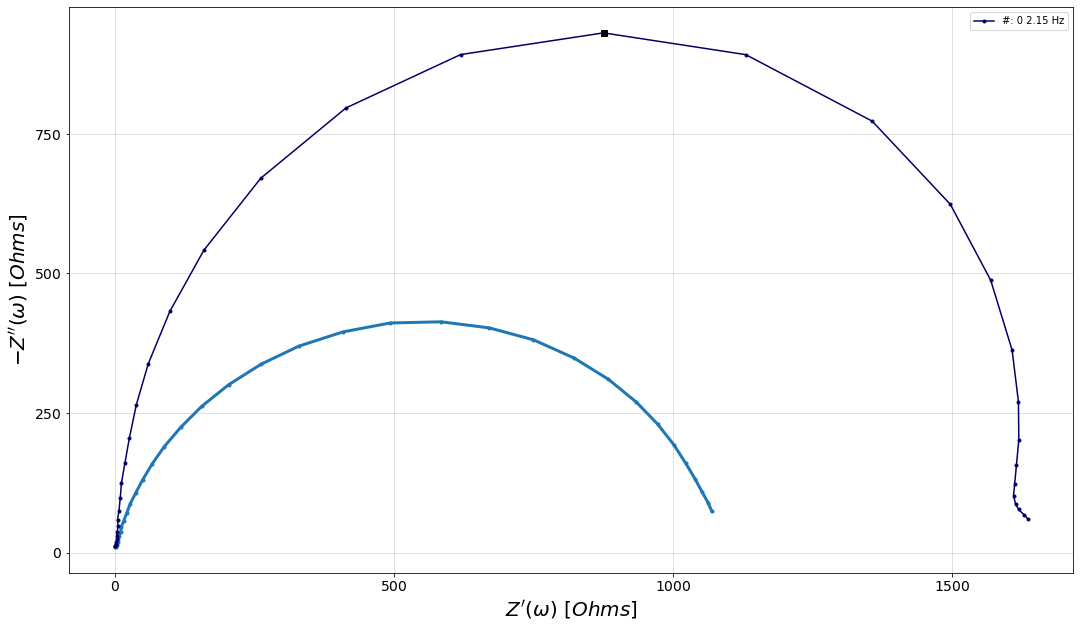

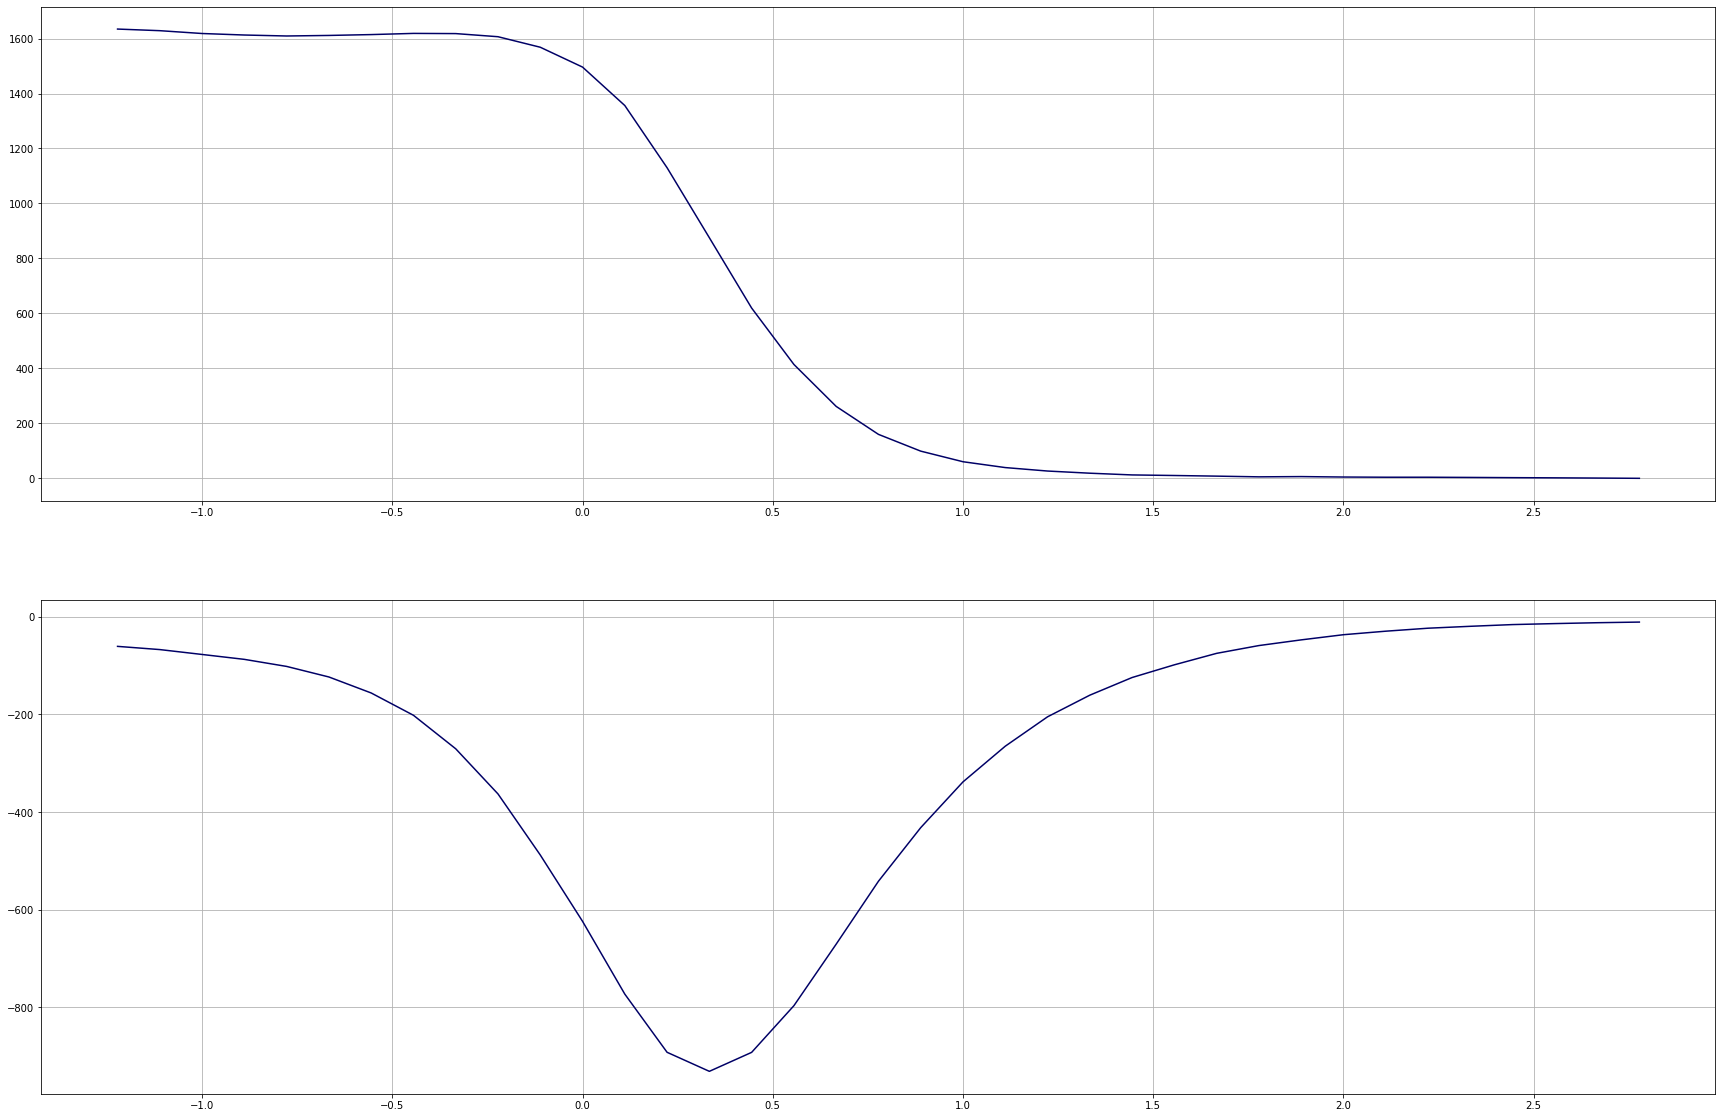

In [660]:
aa, b = IC.sub_Zg_parallel(f_adj, Z_adj, .7, [3149.110580747812], num=1)
aa = np.array(aa)

In [424]:
duma = sum(np.diff(-np.angle(a[0], deg=True)))
dumb = np.angle(a[0,-1], deg=True)
dumc = np.angle(a[0,0], deg=True)
print(duma, dumb, dumc, duma+dumb)

-89.19544260159128 -3.4481781801103644 -92.64362078170166 -92.64362078170164


In [402]:
duma = sum(np.diff(-np.angle(yy[0][0], deg=True)))
dumb = np.angle(yy[0][0,-1], deg=True)
dumc = np.angle(yy[0][0,0], deg=True)
print(duma, dumb, dumc, duma+dumb, duma+dumb-dumc)

-91.56456575221839 -2.4863056578221627 -94.05087141004053 -94.05087141004054 -1.4210854715202004e-14


      fun: 7274.213986739465
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00109139])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 92
      nit: 8
   status: 0
  success: True
        x: array([4348.16770426])


2.154435

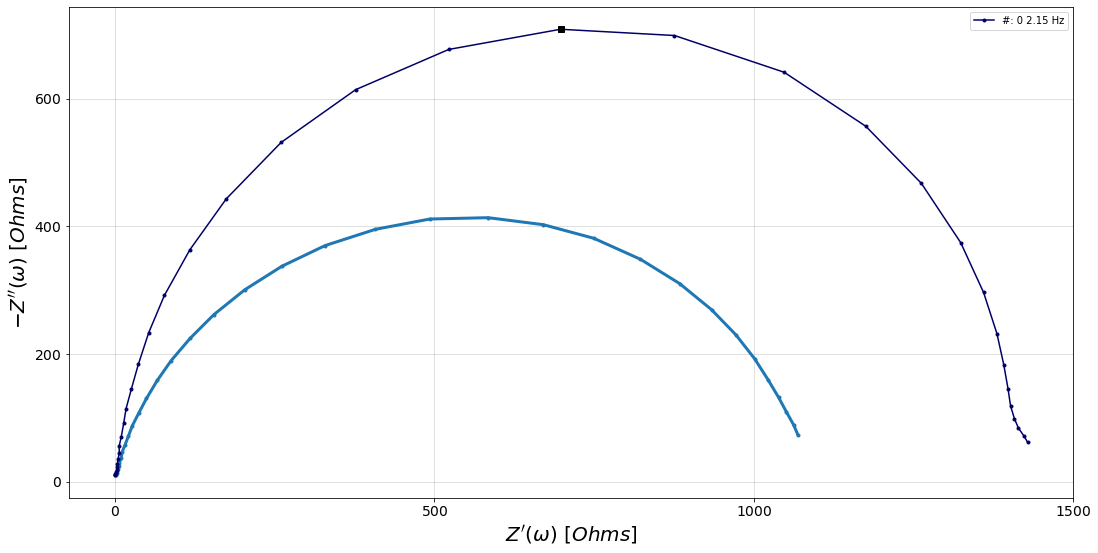

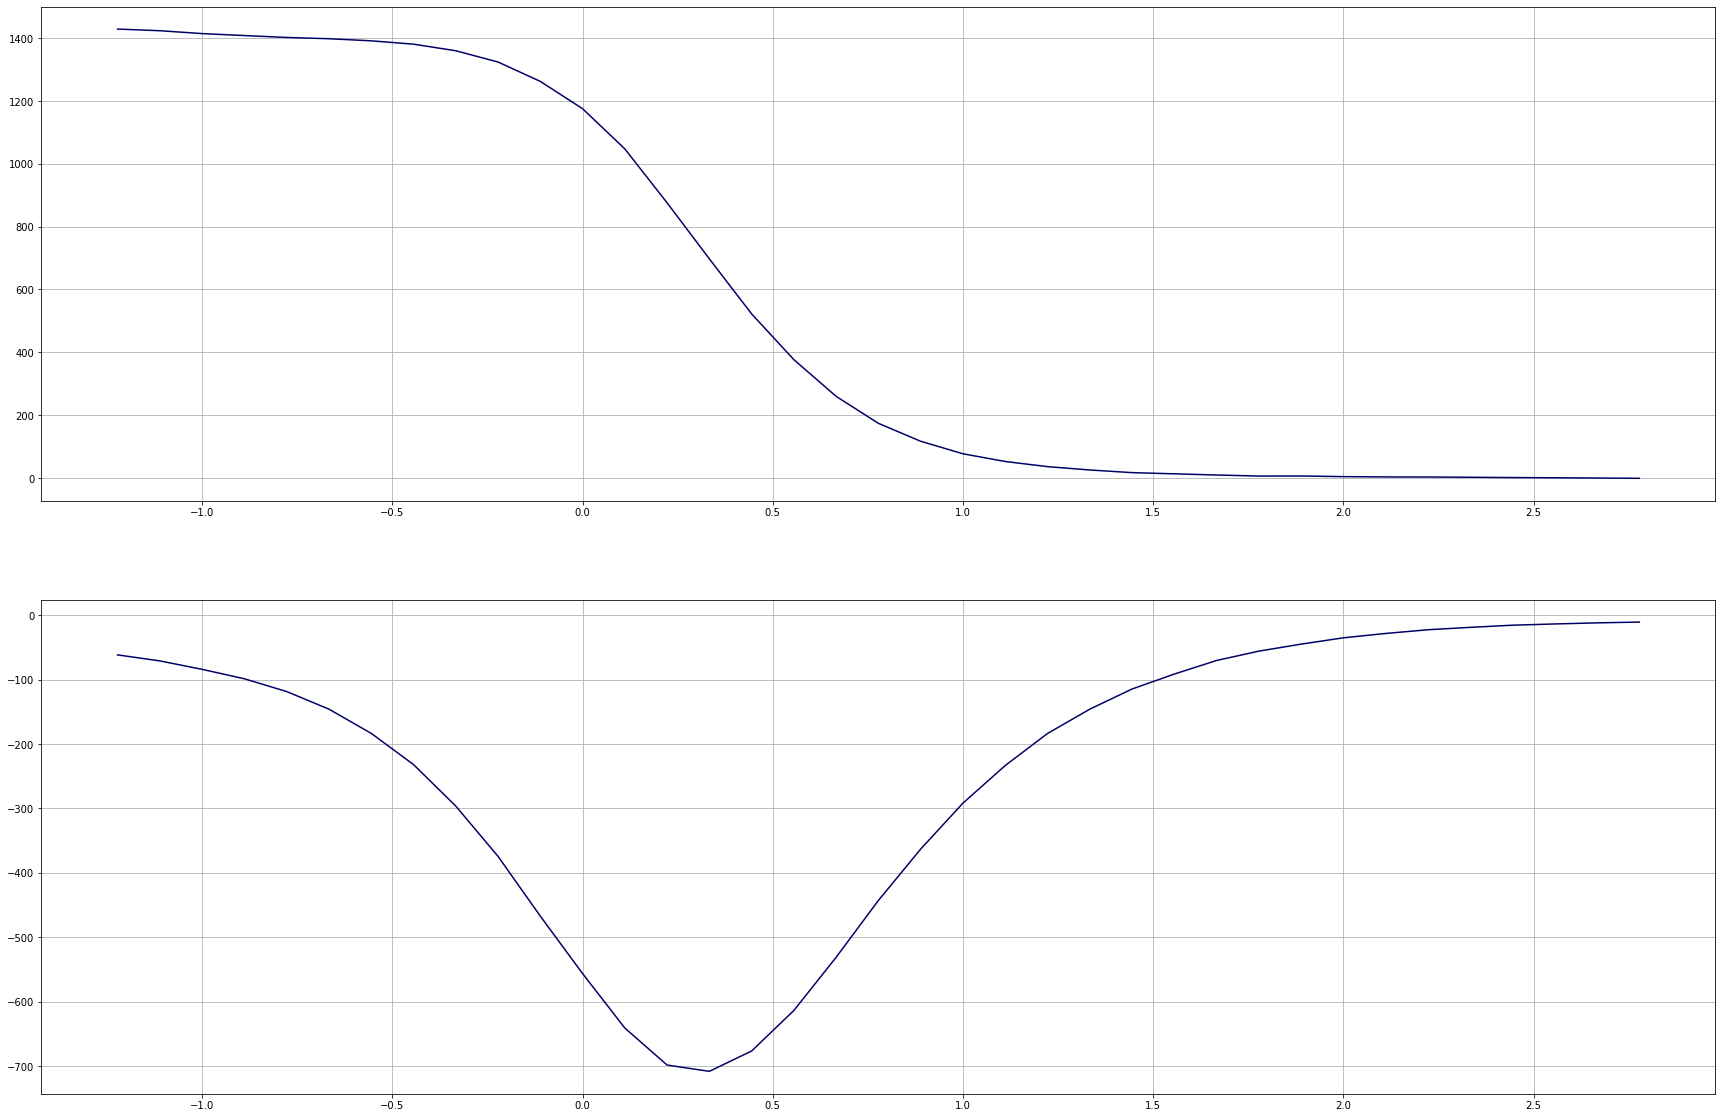

In [678]:
Zg0 = [5000] #, 0.7]
tg0 = 0.795
opts = {'maxiter': 10000}
Zg_fit = minimize(IC.Par_Zg_Res, Zg0, method='L-BFGS-B', args=(f_adj, Z_adj, tg0), bounds=((0, None),), options=opts)
# Zg_fit = minimize(Res_fun, Zg0, args=(f_adj, Z_adj, tg0), bounds = ((0, None),), options=opts)
print(Zg_fit)
# IC.sub_Zg_parallel(f_adj, Z_adj, Zg_fit.x[1], [Zg_fit.x[0]], num=1)
yy = IC.sub_Zg_parallel(f_adj, Z_adj, tg0, Zg_fit.x, num=1)
# IC.sub_Zg_parallel(f_adj, Z_adj, .7, [3.5, 4], num=3)
IC.detect_peak_f(f_adj, yy[0])

In [541]:
# np.diff(yy[0])
a = -yy[0][0].imag
b = -np.gradient(yy[0][0].imag, yy[0][0].real)
c = np.gradient(b, yy[0][0].real)
print(a, '\n', b)
# print(c)

[ 10.65206733  11.90061807  13.6392155   15.61269015  19.03625356
  22.81772606  28.74748658  35.68977613  45.81723026  57.03979929
  72.13993706  94.23366379 118.63438719 151.93943784 192.35335978
 246.28359254 310.47949098 390.41328292 481.39212211 584.31037221
 682.1673359  756.66139709 791.81389294 774.35596505 698.51154843
 593.3008801  488.15371383 383.51275002 299.47699833 232.5448751
 184.16381176 147.27491232 120.88705422 101.92580519  87.89442451
  74.92232435  65.69905577] 
 [  1.33221557   1.73878358   2.57769162   3.38691981   4.47682701
  29.8422468   30.90557625   7.12310467 -32.73865194 -28.11170217
   5.92017787   7.3401491    6.7688225    4.26762289   3.94293177
   3.2431508    2.45405196   1.81867208   1.37252994   0.96412708
   0.61846785   0.32351031   0.04487348  -0.24399877  -0.61732756
  -1.05470419  -1.59750033  -2.47487157  -3.69227841  -5.86591496
  -7.10217889  -7.60073263  -6.06875827  -2.47835176  -1.69008407
  -1.41121938  -1.5123435 ]


(1400, 1550)

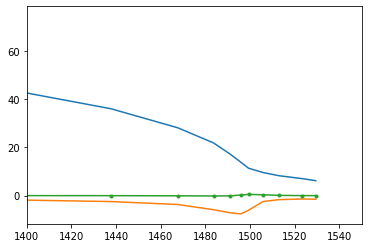

In [542]:
fig, ax = plt.subplots()

ax.plot(yy[0][0,10:].real, a[10:]/np.min(a))
ax.plot(yy[0][0,10:].real, b[10:])
ax.plot(yy[0][0,10:].real, c[10:], '.-')
# ax.plot(np.zeros(np.shape(b)))
ax.set_xlim(1400,1550)
# ax.set_xlim(0,100)
# ax.set_ylim(-4,4)

In [599]:
# np.diff(yy[0])
a = -aa[0].imag
b = -np.gradient(aa[0].imag, aa[0].real)
c = np.gradient(b, aa[0].real)
print(a, '\n', b)
print(c)

[ 10.83033492  12.14915632  13.96622545  16.0153404   19.59045977
  23.53489698  29.7188734   37.01635918  47.79533781  59.59582163
  75.8804016   99.92590225 126.60330303 163.91923915 209.82524473
 272.57626243 349.45917242 449.27344114 567.72276372 709.1500234
 849.69651696 956.79169479 997.87053347 946.951407   804.40780356
 633.18762135 483.17076799 349.67233585 254.43271556 185.93475744
 142.09475654 111.61399179  92.38887661  80.10595825  71.95148068
  63.3541058   58.00718143] 
 [ 1.38579489e+00  1.82644079e+00  2.73695551e+00  3.72814642e+00
  5.15142094e+00 -1.33929905e+02 -1.35139490e+02  1.00918350e+01
 -6.07802282e+01 -2.60073082e+01  9.93813173e+00  1.48821289e+01
  1.46254763e+01  6.58616659e+00  6.16268365e+00  4.92723142e+00
  3.44181880e+00  2.38807062e+00  1.72006148e+00  1.15607826e+00
  7.01096934e-01  3.30703650e-01 -1.92872976e-02 -4.00137383e-01
 -9.93335503e-01 -1.99894362e+00 -4.01184567e+00 -4.27156975e+01
 -7.17933923e+01  8.06869626e+00  4.56657968e+00  4.47

(-10, 10)

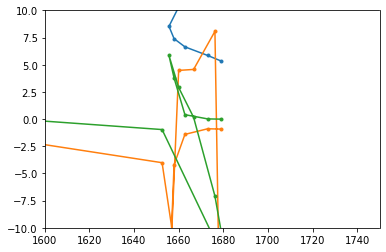

In [598]:
fig, ax = plt.subplots()

ax.plot(aa[0,10:].real, a[10:]/np.min(a), '.-')
ax.plot(aa[0,10:].real, b[10:], '.-')
ax.plot(aa[0,10:].real, c[10:], '.-')
# ax.plot(np.zeros(np.shape(b)))
ax.set_xlim(1600,1750)
# ax.set_xlim(0,100)
ax.set_ylim(-10,10)

In [617]:
xdum = np.zeros(np.shape(c), dtype=bool)
xdum[-10:] = c[-10:] > 0
c[xdum]

array([0.15895279, 2.90471203, 5.84871948, 3.78116791, 0.4050821 ,
       0.0152003 ])

In [575]:
# np.diff(yy[0])
a = -Z_RC.imag
b = -np.gradient(Z_RC.imag, Z_RC.real)
c = np.gradient(b, Z_RC.real)
print(a, '\n', b)
# print(c)

[  1.5915454    2.00363398   2.52241981   3.17552658   3.99772753
   5.03279373   6.33581805   7.97613507  10.04098548  12.64010632
  15.91146389  20.02837967  25.20831933  31.7235954   39.91412211
  50.20204883  63.10737439  79.26210602  99.41743767 124.43254226
 155.22309613 192.63087892 237.15421569 288.46640999 344.68967863
 401.57259455 452.10572095 487.48990188 499.9956089  486.56619564
 450.47724337 399.56317004 342.59738941 286.49487553 235.40880144
 191.145638   153.99069457 123.42618358  98.60396699  78.60876871
  62.58477827  49.78510424  39.58200954  31.45932589  24.99817012
  19.86133559  15.77871757  12.53463284   9.95719021   7.90956676
   6.28293727   4.99078718   3.96435961   3.14902104   2.50136547
   1.98690981   1.57826086   1.25365832   0.99581677   0.79100567
   0.62831828] 
 [ 2.78148417e+02  2.56016817e+02  2.03360909e+02  1.61534710e+02
  1.28310825e+02  1.01919958e+02  8.09567009e+01  6.43046832e+01
  5.10771245e+01  4.05696089e+01  3.22225729e+01  2.55915064e

(-10, 10)

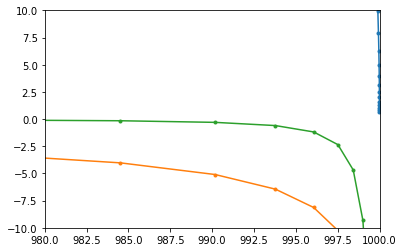

In [596]:
fig, ax = plt.subplots()

ax.plot(Z_RC[10:].real, a[10:], '.-')
ax.plot(Z_RC[10:].real, b[10:], '.-')
ax.plot(Z_RC[10:].real, c[10:], '.-')
# ax.plot(np.zeros(np.shape(b)))
ax.set_xlim(980,1000)
# ax.set_xlim(0,100)
ax.set_ylim(-10,10)

In [562]:
result = least_squares(Res_fun, 10**3.9, args=(f_adj, Z_adj, .7), bounds=([1e3], [1e4]))
result

25 [7943.28234724] 111.7393467799272 -523.2112477354639
25 [7943.28246561] 111.73931917541002 -523.2112456153818
25 [8331.87893043] 43.14049219014433 -516.6584255353006
25 [8331.87905459] 43.140476507044845 -516.6584235642894
25 [8615.36081457] 15.74859757995479 -512.3423772520252
25 [8615.36094294] 15.74858866911672 -512.3423753775082
25 [8810.30717943] 5.365572541956196 -509.5738694838757
25 [8810.30731071] 5.36556754739753 -509.5738676705469
25 [8936.39565012] 1.693375422226667 -507.86262568584795
25 [8936.39578328] 1.693372687077841 -507.8626239100639
25 [9012.90812703] 0.49643767727570887 -506.8529658693685
25 [9012.90826133] 0.4964362187232353 -506.85296411563735
25 [9056.59666991] 0.13700350227323424 -506.28586491980724
25 [9056.59680486] 0.1370027426200775 -506.28586317843036
25 [9080.32346948] 0.036244009962200105 -505.9806897043502
25 [9080.32360478] 0.03624362105401201 -505.9806879696119
25 [9092.76278095] 0.00934215258387034 -505.8214769048495
25 [9092.76291644] 0.009341955

 active_mask: array([0])
        cost: 1.7288291502534183e-13
         fun: array([5.88018563e-07])
        grad: array([-6.75094863e-12])
         jac: array([[-1.14808427e-05]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 16
        njev: 16
  optimality: 6.038464309158563e-09
      status: 1
     success: True
           x: array([9105.53840105])

[1.23157757e+03 1.05151185e-04 8.71633912e-01]
[9.13911096e+03 7.44443571e-01]


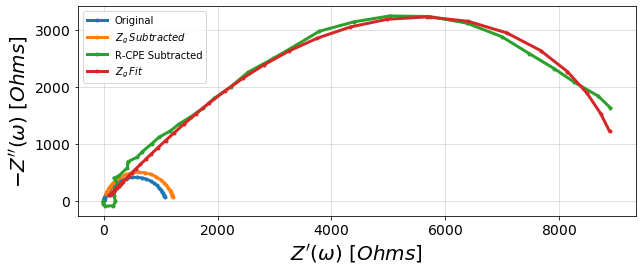

In [588]:
par_out= IC.sub_Zg_parallel(f_adj, Z_adj, .7, result.x, num=11, show_plot=False)

f_p = f_adj[np.argmin(par_out.imag)]
C_guess = 1 / (2*np.pi * f_p * par_out[0, -1].real)
# PostZg = CustomCircuit(circuit='R0-p(R1,E1)', initial_guess=[par_out[0,15].real, par_out[0,-1].real, C_guess, .8])
PostZg = CustomCircuit(circuit='p(R1,E1)', initial_guess=[par_out[0,-1].real, C_guess, .8])
PostZg.fit(f_adj[15:], par_out[0, 15:])
print(PostZg.parameters_)
Z_pZg = PostZg.predict(f_adj[15:]) 

ZZ = IC.par_RCPE_subtract(PostZg.parameters_[:], f_adj, Z_adj)
ZZ2 = IC.par_RCPE_subtract([1227.361, 8.5e-5, .90185877], f_adj, Z_adj)

dum_circ = CustomCircuit(circuit='R1-G', initial_guess=[None, 12000, .7], constants={'R1': 0})
dum_circ.fit(f_adj, ZZ)

ZZ_p = dum_circ.predict(f_adj)
print(dum_circ.parameters_)

fig, ax = plt.subplots(figsize=(10,10))
plot_nyquist(ax, Z_adj, label='Original', lw=3)
plot_nyquist(ax, Z_pZg, label='$Z_g \: Subtracted$', lw=3)
# plot_nyquist(ax, par_out[0], label='Fit', lw=3)
plot_nyquist(ax, ZZ, label='R-CPE Subtracted', lw=3)
# plot_nyquist(ax, ZZ2)
plot_nyquist(ax, ZZ_p, label=r'$Z_g \: Fit$', lw=3)

# ax.set_xlim(0,800)
# ax.set_ylim(-200,700)
ax.legend()
fig.savefig(r'Figures\Berthier Correction\10%O2 Data Zg Fit ', dpi=300, bbox_inches='tight')

In [514]:
dum_circ = CustomCircuit(circuit='R1-G', initial_guess=[None, 12000, .2], constants={'R1': 800})
dum_circ.fit(f_adj, ZZ)

ZZ_p = dum_circ.predict(f_adj)



In [438]:
RC0 = PostZg.parameters_[1:]
print(RC0)
d_st = 3e-16
x_t = xtol=3e-16
f_t = ftol=3e-16
g_t = gtol=3e-16


resRCPE = least_squares(IC.Par_RCPE_Res, RC0, method= 'trf', args=(f_adj, Z_adj), max_nfev=2000, diff_step=d_st, xtol=x_t, ftol=f_t, gtol=g_t)
resRCPE

[1.23544968e+03 1.04482330e-04 8.68185877e-01]


 active_mask: array([0., 0., 0.])
        cost: 0.00016073652157873412
         fun: array([0.01792967])
        grad: array([ 0.00000000e+00, -3.49059286e+01, -2.24120867e-03])
         jac: array([[ 0.00000000e+00, -1.94682501e+03, -1.25000000e-01]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 58
        njev: 23
  optimality: 34.90592864082627
      status: 3
     success: True
           x: array([1.23544968e+03, 4.50822966e-06, 8.68185321e-01])

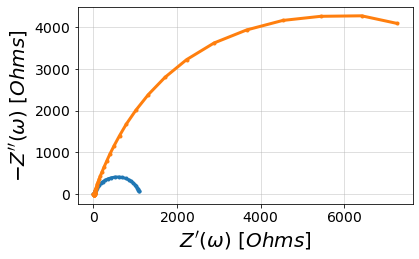

In [423]:
ZZZ = IC.par_RCPE_subtract(resRCPE.x, f_adj, Z_adj)

fig, ax = plt.subplots()
plot_nyquist(ax, f_adj, Z_adj)
plot_nyquist(ax, f_adj, ZZZ)

In [144]:
direc = r'\Data'
print(os.getcwd())
all_files=glob.glob(os.getcwd() + direc + '\*1%*.par')
all_files.sort()

f_name=all_files[-1]
print(f_name)
f0, Z0 = preprocessing.readVersaStudio(f_name)

freqs, Z1 = preprocessing.ignoreBelowX(f0, Z0)

Z = Z1 - Z1.real[0]

C:\Users\shadd\OneDrive\Documents\Python\EIS
C:\Users\shadd\OneDrive\Documents\Python\EIS\Data\LSC_DPB1_FRXAS_700C_100%_EIS_OCV_before2.par


24 (686.898087322533-562.8687843225954j) 12.825167569241444 0 0
24 (674.9713187380408-553.6919165768278j) 10.323176303795321 0 0
24 (663.9611183159086-545.2024563688464j) 8.081499163629246 0 0
24 (653.7761633035259-537.3340279601216j) 6.066164418275321 0 0
24 (644.3366909504435-530.0283880749315j) 4.248518621541052 0 0
24 (635.5727239749295-523.2342167977613j) 2.6042632756787043 0 0
24 (627.4226133300834-516.9061180157194j) 1.1126883454375616 0 0
24 (619.8318340094988-511.0037882517951j) -0.2439419269109635 0 0
24 (612.7519840830935-505.49132171376755j) -1.4808844457147075 0 0
24 (606.1399480493834-500.3366262185423j) -2.611319394146733 0 0
24 (599.9571938768203-495.51092989642814j) -3.6466785708575458 0 0


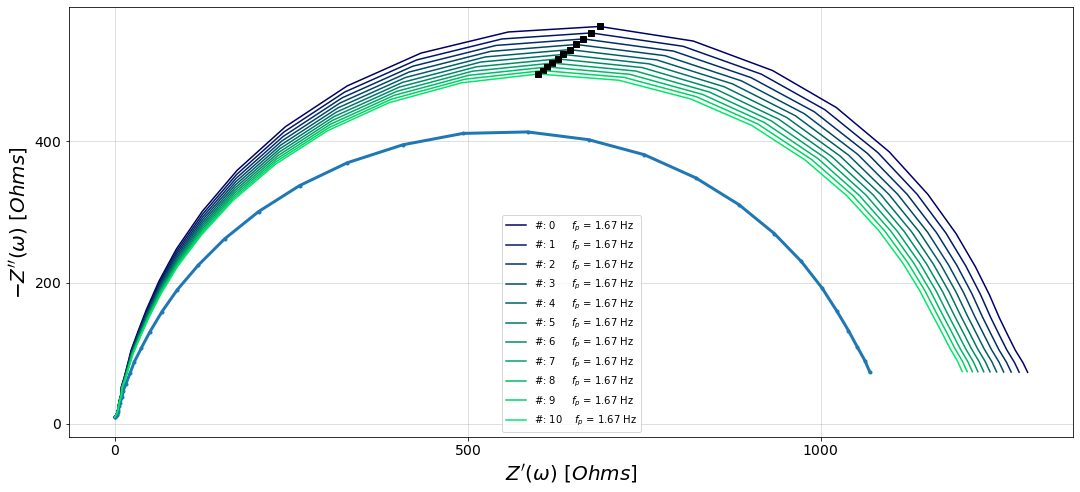

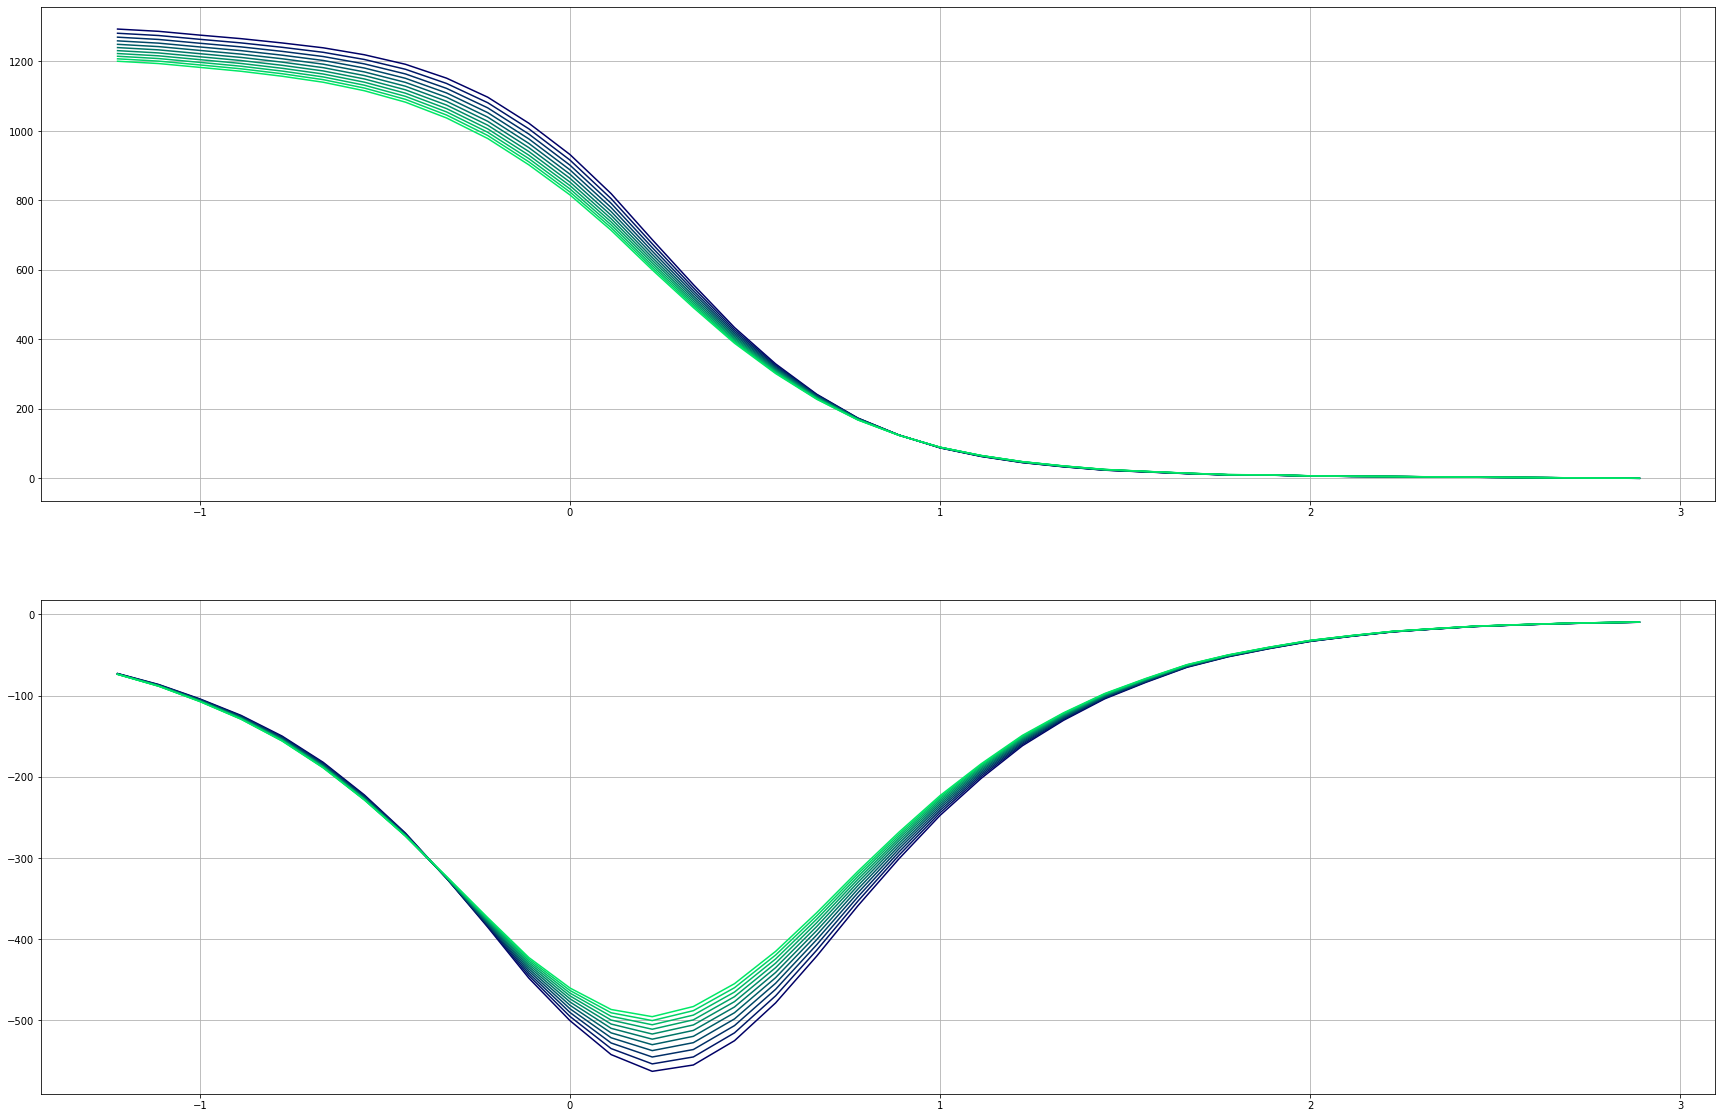

In [331]:
# par_out, ax0, ax1, ax2 = IC.sub_Zg_parallel(f_adj, Z_adj, .7, [3.3, 3.8], num=13)
par_out = IC.sub_Zg_parallel(f_adj, Z_adj, .91, [3.8, 4], num=11, show_plot=False)
# ax0.set_xlim((-2, 20))
# ax0.set_ylim((-2, 20))
fig, ax = plt.subplots(figsize=(18, 12))
fig2, (ax1, ax2) = plt.subplots(nrows=2, figsize=(30, 20))
plot_nyquist(ax, freqs, Z_adj)

for i, Zs in enumerate(par_out):
#     print(sum(n < 0 for n in np.diff(Zs)), sum(n < -1 for n in Zs.real))
    min_ind = np.argmin(Zs.imag)
    print(min_ind, Zs[min_ind], Zs[min_ind+1].imag - Zs[min_ind-1].imag, sum(n < 0 for n in np.diff(Zs)), sum(n < -1 for n in Zs.real))
    if sum(n < 0 for n in np.diff(Zs)) == 0 and sum(n < -1 for n in Zs.real) < 2:
        f_p_idx = np.argmin(np.imag(Zs))
        f_p = f_adj[f_p_idx]

        ax.plot(Zs.real, -Zs.imag, label='#: %d \t $f_p$ = %.2f Hz' % (i, f_p),
                c=(0, i/len(par_out), .4))
        ax.plot(Zs[f_p_idx].real, -Zs[f_p_idx].imag, 's',
                c=(0, 0, 0))
        ax1.plot(np.log10(f_adj), Zs.real, label='%.2f Hz' % f_p,
                c=(0, i/len(par_out), .4))
        ax2.plot(np.log10(f_adj), Zs.imag, label='%.2f Hz' % f_p,
                c=(0, i/len(par_out), .4))

        # ax.set_xlim(-80, 300)
        # ax.set_ylim(-80, 300)
        ax1.grid(True)
        ax2.grid(True)
        ax.legend()
        

C:\Users\shadd\OneDrive\Documents\Python\EIS


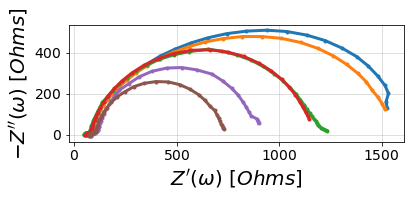

In [15]:
direc = r'\Data'
print(os.getcwd())
all_files=glob.glob(os.getcwd() + direc + '\*.par')
all_files.sort()

fig, ax = plt.subplots()

for file in all_files:
    f, Z = preprocessing.readVersaStudio(file)
    plot_nyquist(ax, f, Z)

    
# ax.set_xlim(40,150)
# ax.set_ylim(0,100)
plt.show()

In [173]:
all_files

['C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_1%_EIS_OCV_before.par',
 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_1%_EIS_OCV_before2.par',
 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_10%_EIS_OCV_after.par',
 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_10%_EIS_OCV_afterFRXAS.par',
 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_100%_EIS_OCV_after.par',
 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\EIS\\Data\\LSC_DPB1_FRXAS_700C_100%_EIS_OCV_before2.par']

In [143]:
from impedance.validation import linKK

In [8]:
from scipy.optimize import brute
from scipy.optimize import minimize

In [45]:
Ns = 100
Q_st = -4.7
Q_end = -4.3
al_st = .95
al_end = 1.


rrange = ((Q_st, Q_end), (al_st, al_end))
Qs = np.linspace(Q_st, Q_end, num=Ns)
als = np.linspace(al_st, al_end, num=Ns)

In [46]:
result, f_eval, grid, evals = brute(IC.Par_CPE_Res_log, rrange, Ns=Ns, args=(f_adj, Z_adj), full_output=True, disp=True, finish=None)

opts = {'maxiter': 10000}
C0 = [-6, .8]

# CPE_fit2 = minimize(IC.Par_CPE_Res_log, C0, method='TNC', args=(pred_freq[:], BC_pred[:]), bounds=((-10, 0), (0, 1)), options=opts)
CPE_fit2 = minimize(IC.Par_CPE_Res_log, C0, method='L-BFGS-B', args=(f_adj, Z_adj), bounds=((-10, 0), (0, 1)), options=opts)

print('Minimize \n', CPE_fit2)

Minimize 
       fun: 8.187216954939935e-05
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.72934034e-06, -5.24224571e-05])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 72
      nit: 4
   status: 0
  success: True
        x: array([-4.52554421,  1.        ])


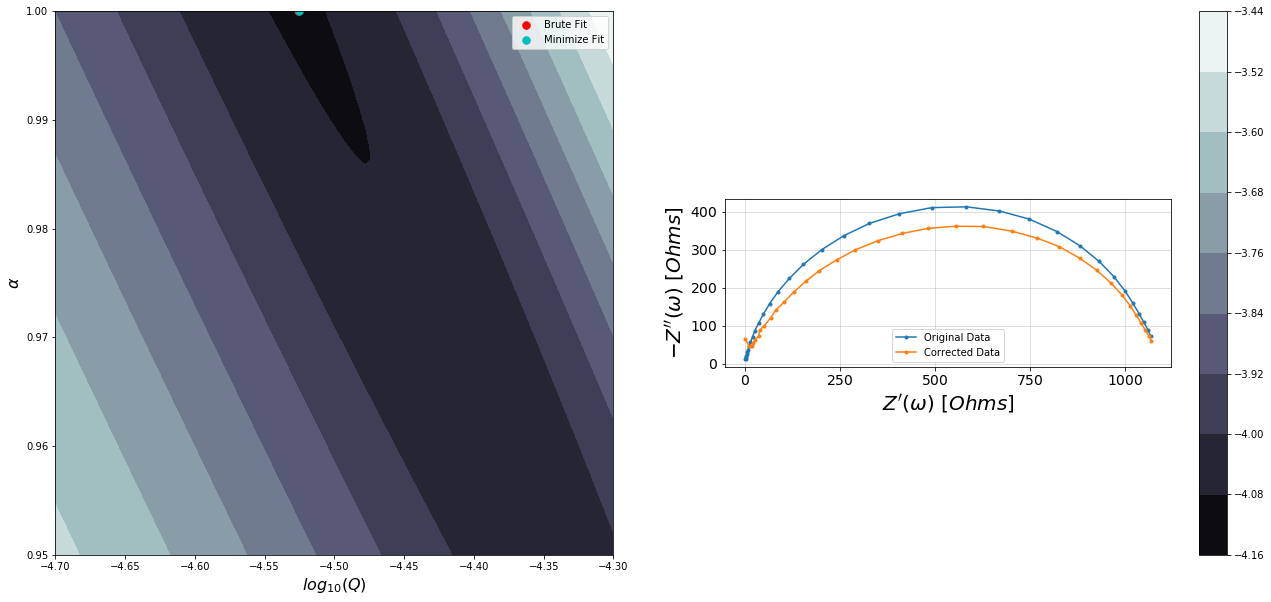

In [47]:
fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(22, 10))
CS = ax.contourf(grid[0], grid[1], np.log10(evals), cmap=plt.cm.bone) #, levels=np.linspace(-2.4, 1.6, 10))

ax.plot(result[0], result[1], 'r.', ms=15, label='Brute Fit')
ax.plot(CPE_fit2.x[0], CPE_fit2.x[1], 'c.', ms=15, label='Minimize Fit')
cbar = fig.colorbar(CS)
ax.set_xlabel(r'$log_{10}(Q)$', fontsize=16)
ax.set_ylabel(r'$\alpha$', fontsize=16)
ax.legend()

Z_corr = IC.par_CPE_subtract_log(CPE_fit2.x, f_adj, Z_adj)

plot_nyquist(ax2, Z_adj, label='Original Data')
plot_nyquist(ax2, Z_corr, label = 'Corrected Data')

ax2.legend()

plt.show()

Simulating circuit based on initial parameters


2563.5750280269185

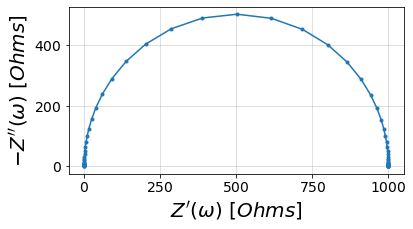

In [586]:
RC = CustomCircuit(circuit='p(R1,C1)', initial_guess=[1000, 1e-5])

dum_f = np.logspace(-2, 4, num=61)
#Making frequencies high to low
dum_f[::-1].sort()
Z_RC = RC.predict(dum_f)
fig, ax = plt.subplots()
plot_nyquist(ax, Z_RC)
sum(-np.angle(Z_RC, deg=True))

Simulating circuit based on initial parameters


-71.95219417317654

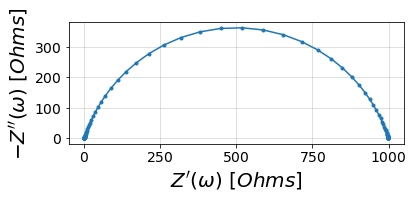

In [281]:
RE = CustomCircuit(circuit='p(R1,E1)', initial_guess=[1000, 5e-5, .8])

dum_f = np.logspace(-3, 7, num=101)
#Making frequencies high to low
dum_f[::-1].sort()
Z_RE = RE.predict(dum_f)
fig, ax = plt.subplots()
plot_nyquist(ax, Z_RE)
sum(np.diff(-np.angle(Z_RE, deg=True)))

Simulating circuit based on initial parameters


-89.83791734683778

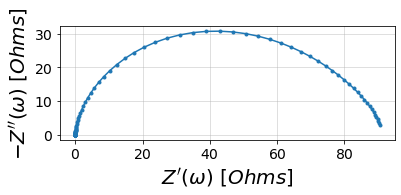

In [298]:
GG = CustomCircuit(circuit='p(G1,p(R1,C1))', initial_guess=[1000, .1, 100, 1e-5])

dum_f = np.logspace(-0, 7, num=101)
#Making frequencies high to low
dum_f[::-1].sort()
Z_GG = GG.predict(dum_f)
fig, ax = plt.subplots()
plot_nyquist(ax, Z_GG)
sum(np.diff(-np.angle(Z_GG, deg=True))) + np.angle(Z_GG[-1], deg=True)

In [256]:
IC.detect_peak_f(dum_f, Z_RC)

15.848931924611142

In [282]:
sum(np.diff(-np.angle(Z_adj, deg=True)))

-86.05387453483308

In [311]:
sum(np.diff(-np.angle(a[0], deg=True))) + np.angle(a[0,-1], deg=True)

-95.3258257310256